# ESS 330 Final Project: Emissions in the Top CO₂ Polluting Countries

Before and After COVID-19

Yazeed Aljohani (Colorado State University)  
Josh Puyear (Colorado State University)  
Cade Vanek (Colorado State University)  
April 24, 2025

This project investigates trends in per capita greenhouse gas (GHG) emissions from the five largest CO2-polluting countries before, during, and after the COVID-19 pandemic. Using `ghg_excluding_lucf_per_capita` as the main \[response?\] variable, we analyze patterns in emissions and identify key predictors across sectors (e.g., manufacturing, transport). The study applies workflow modeling and ANOVA to examine emission changes and variation across countries. Results will inform strategies to reduce emissions and guide sustainable policy efforts.

# Introduction, Background, and Motivation

Climate change remains one of the most urgent global challenges, driven in large part by human greenhouse gas emissions. Among these, carbon dioxide is the most significant. Carbon dioxide is released through many activities such as burning fossil fuels, industrial production, and land-use practices. Even though international efforts like the Paris Agreement have pushed countries to reduce emissions, many continue to show increasing trends. A small group of countries contributes the most emissions globally, both in total and per person. These major contributors include countries like China, the United States, and India ([Friedlingstein et al., 2019](#ref-friedlingstein2019global)).

This project focuses on the five largest carbon dioxide polluting countries: China, the United States, India, Russia, and Japan. These countries are responsible for a significant share of global emissions and reflect a range of economic systems, energy sources, and industrial structures. To allow meaningful comparisons, we center our analysis on greenhouse gas emissions per person, using the variable ghg_excluding_lucf_per_capita. This variable removes land-use change from the emissions total, isolating emissions from industrial activity and fossil fuel use. By using this approach, we can better understand how much pollution is tied to each person’s activity and consumption within each country.

The COVID-19 pandemic created a global disruption that affected travel, trade, and production. Lockdowns and other restrictions slowed down factories, reduced transportation, and caused shifts in energy use. As a result, global carbon dioxide emissions in 2020 dropped by approximately 5.4 percent, marking the largest single-year decrease in history ([Forster et al., 2020](#ref-forster2020current)). This sudden drop was mostly due to temporary changes. As countries began reopening in 2021 and 2022, emissions started climbing again.

Our goal is to analyze how emissions changed in these five countries before, during, and after the pandemic. We look at three main periods: before COVID from 2015 to 2019, the year COVID began in 2020, and the early recovery years from 2021 to 2022. By studying per person emissions during these periods, we can see whether there were real shifts in emissions behavior and whether those shifts continued into recovery. We also want to understand what kinds of emissions changed the most. For example, did transportation-related emissions drop more than industrial ones? Did countries with manufacturing-based economies recover differently than those with service-based ones?

To explore these questions, we use two main methods. First, we build a workflow model using the tidymodels package in R. This lets us see which emission sources are the strongest predictors of overall greenhouse gas output per person. For example, we compare emissions from coal, oil, gas, cement, and other industry sectors. We also include factors like population and economic output. By analyzing these predictors, we can understand which sources matter most in each country and how they are connected to changes over time. Second, we use ANOVA to test whether the changes in emissions across the three time periods are statistically meaningful. We run this analysis for each country and compare their patterns.

The reason for focusing on per person emissions is that total emissions alone do not tell the full story. Countries with large populations may seem like major polluters in total, but their emissions per person might be lower than smaller, high-emitting countries. A per person view also reflects differences in daily life, energy use, and infrastructure. This is important for climate policy, because it shows whether emissions are driven by large populations, high-intensity consumption, or both.

Our analysis helps link data analysis to climate solutions. By identifying what types of emissions dropped the most during the pandemic and which ones came back quickly, we can suggest where to focus efforts. If, for instance, oil-related emissions dropped during lockdowns but then returned quickly, that might show a need for deeper investment in alternative transportation options. If manufacturing emissions remained stable, that could show how industrial processes are harder to change without long-term plans and policies.

This project is also a chance to make emissions data more relatable. People often hear that emissions went down during the pandemic, but they may not know what caused the change or how long it lasted. By using clear visuals and country comparisons, we can help explain these trends to wider audiences. This is especially important as the world faces increasing climate-related disasters. Understanding emission trends can support smarter planning and better communication around sustainable transitions.

Lastly, we are motivated by a bigger question: what can we learn from this accidental global experiment? The pandemic gave the world a chance to see what happens when daily life suddenly changes. Some of those changes, like working from home or using less transportation, might become long-term habits. Others may disappear as economies reopen. By analyzing which emission reductions lasted and which faded, we can start to imagine more realistic and effective ways to slow down climate change.

# **Data Exploration**

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Rows: 50191 Columns: 79
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): country, iso_code
dbl (77): year, population, gdp, cement_co2, cement_co2_per_capita, co2, co2...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 79 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): column, description, unit, source

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Narrowing Data to 2015-2022

In [ ]:
data_filtered <- data |>
  filter(year >= 2015, year <= 2022) |>
  filter(!is.na(iso_code) & nchar(iso_code) == 3)

In [ ]:
# Getting top 5 CO2 emitting countries by total GHG (excluding land use)- This is total cumulative ghg emissions

top_emitters <- data_filtered |>
  group_by(country) |>
  summarise(total_ghg = sum(total_ghg_excluding_lucf, na.rm = TRUE)) |>
  arrange(desc(total_ghg)) |>
  slice_head(n = 5) |>
  pull(country)

# Filtering data to include only those countries and select relevant variables
df <- data_filtered |>
  filter(country %in% top_emitters) |>
  select(country, year, ghg_excluding_lucf_per_capita,
         coal_co2, gas_co2, oil_co2, cement_co2, other_industry_co2)

In [ ]:
# Adding period category (pre, during, post COVID)
df <- df |>
  mutate(period = case_when(
    year <= 2019 ~ "pre_covid",
    year == 2020 ~ "during_covid",
    year >= 2021 ~ "post_covid"
  )) |>
  mutate(period = factor(period, levels = c("pre_covid", "during_covid", "post_covid")))

Per capita ghg emissions top 5 polluters

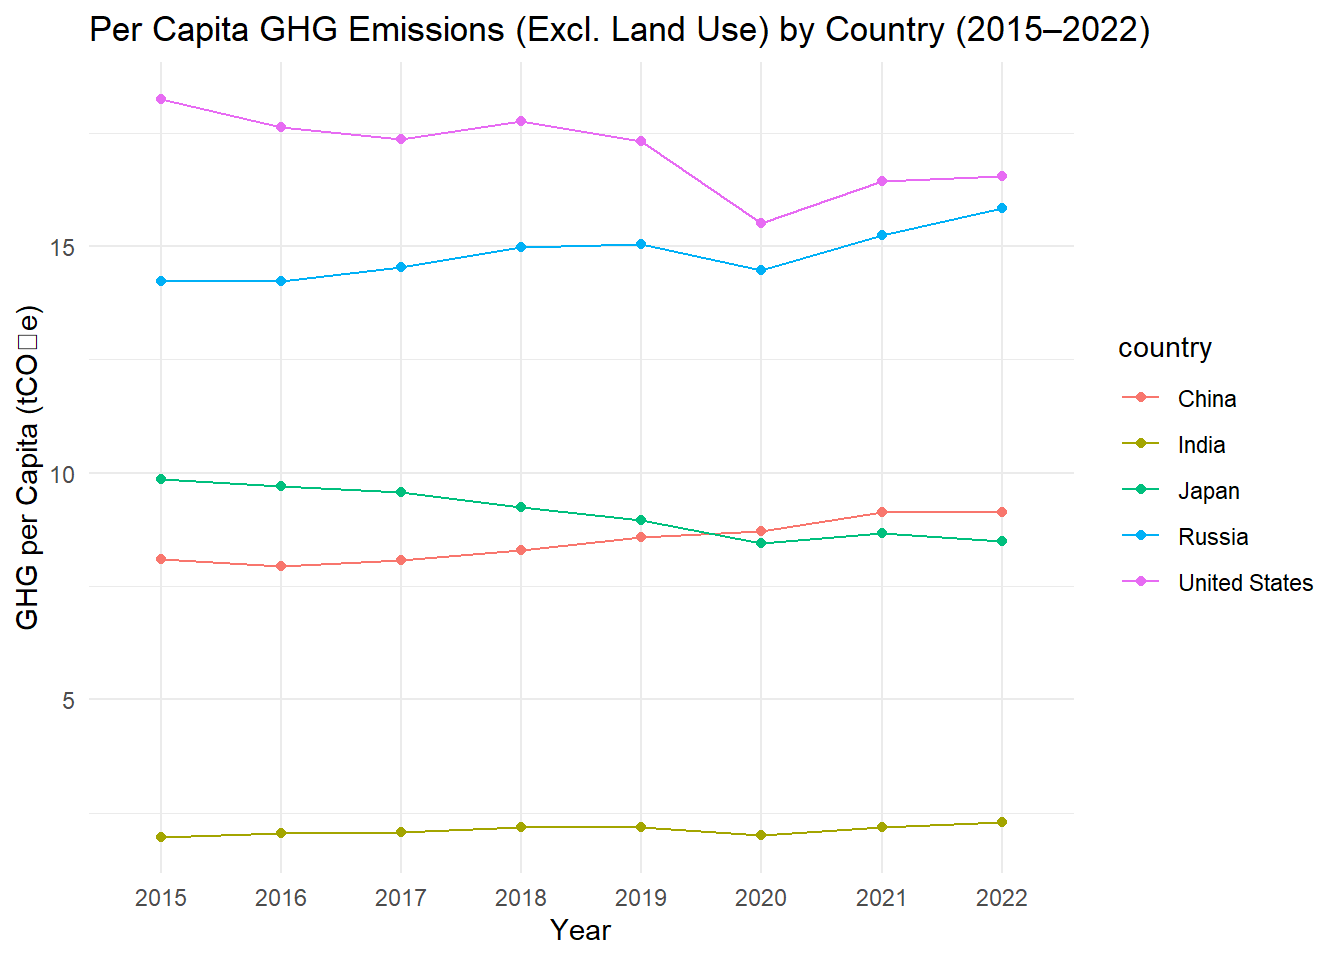

In [ ]:
ggplot(df, aes(x = factor(year), y = ghg_excluding_lucf_per_capita, color = country, group = country)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Per Capita GHG Emissions (Excl. Land Use) by Country (2015–2022)",
    x = "Year", y = "GHG per Capita (tCO₂e)"
  ) +
  theme_minimal()

(`geom_line()`).

(`geom_point()`).

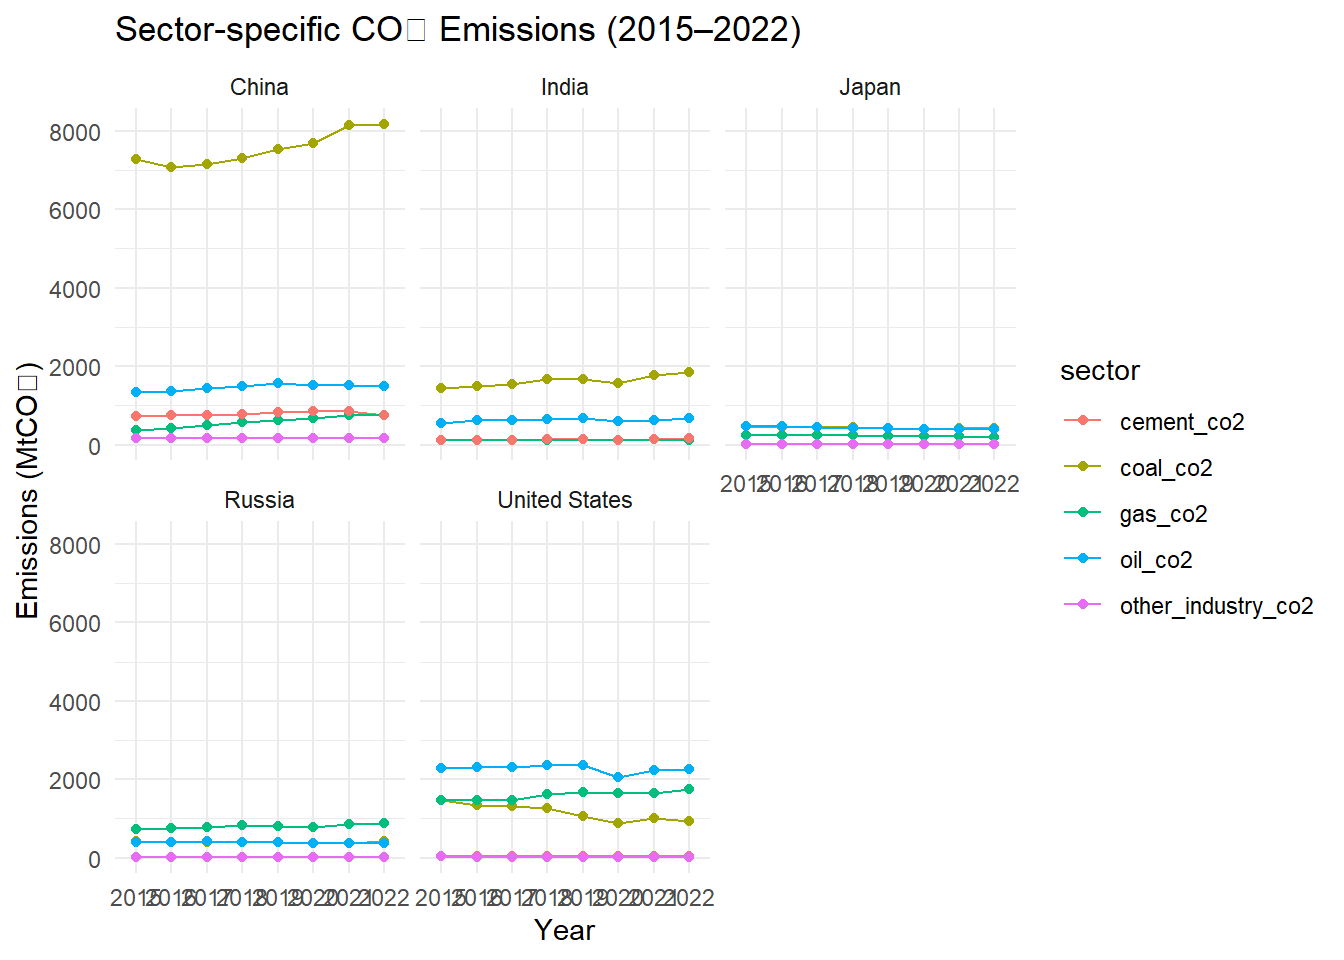

In [ ]:
df_long <- df |>
  pivot_longer(cols = c(coal_co2, gas_co2, oil_co2, cement_co2, other_industry_co2),
               names_to = "sector", values_to = "emissions")

ggplot(df_long, aes(x = factor(year), y = emissions, color = sector, group = interaction(sector, country))) +
  geom_line() +
  geom_point() +
  facet_wrap(~ country) +
  labs(title = "Sector-specific CO₂ Emissions (2015–2022)", x = "Year", y = "Emissions (MtCO₂)") +
  theme_minimal()

In [ ]:
# Running ANOVA on each country if they have more than one period
for (c in unique(df$country)) {
  df_country <- df |> filter(country == c)
  if (n_distinct(df_country$period) > 1) {
    cat("\n--- ANOVA for", c, "---\n")
    model <- aov(ghg_excluding_lucf_per_capita ~ period, data = df_country)
    print(summary(model))
  } else {
    cat("\n--- Skipped ANOVA for", c, ": not enough periods ---\n")
  }
}


--- ANOVA for China ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.2803  0.6402   13.06 0.0103 *
Residuals    5 0.2451  0.0490                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for India ---
            Df  Sum Sq  Mean Sq F value Pr(>F)
period       2 0.04456 0.022280   2.956  0.142
Residuals    5 0.03769 0.007537               

--- ANOVA for Japan ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.6155  0.8077   7.299 0.0329 *
Residuals    5 0.5533  0.1107                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for Russia ---
            Df Sum Sq Mean Sq F value Pr(>F)  
period       2 1.3923  0.6961   4.433 0.0781 .
Residuals    5 0.7852  0.1570                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- ANOVA for United States ---
            Df Sum Sq Mean Sq F value  Pr(>F)   
period       2  4.906  2.4529   21.37 0.00355 **
Res

#### Data Description

We used data from Our World in Data’s greenhouse gas emissions dataset, which compiles country-level data from sources like the Global Carbon Project and BP Statistical Review ([Samborska, 2025](#ref-owid-scaling-up-ai)). The dataset covers emissions from fossil fuels, industry, and land-use change.

For this project, we focused on the years 2015 to 2022 and selected the top five CO₂-polluting countries: China, the United States, India, Russia, and Japan. We used variables such as:

-   ghg_excluding_lucf_per_capita (our main variable),

-   Sector-based emissions: coal_co2, oil_co2, gas_co2, cement_co2, other_industry_co2.

#### Data Cleaning

We filtered the dataset to include:

-   Only rows with valid ISO country codes

-   Only years 2015–2022

-   The top 5 countries based on total GHG emissions (excluding land-use change)

We also created a period variable to group data into pre-COVID (2015–2019), during COVID (2020), and post-COVID (2021–2022). This helped us compare emissions trends across time. Minimal cleaning was needed beyond this filtering and labeling.

# Methods

Our reseach focuses on revealing relationships between countries and between predictor variables of greenhouse emissions per capita excluding land use. The dataset from Our World in Data includes emissions levels from the industrial revolution up to 2023 and is a robust dataset. The data are compiled from \[sources\]. The dataset is publicly posted to https://ourworldindata.org/co2-and-greenhouse-gas-emissions. To compare CO2 emissions before, during, and after the pandemic, we will be using the tidymodels package in R along with dplyr and \[other packages\]. We will make this comparison by comparing transportation and industrial emissions, then comparing total emissions from five key predictor categories including coal, oil, gas, cement and other. Our main predictor will be ghg_excluding_lucf_per_capita. We will be using modeltime to make a timeseries model against which predictor variables can be tested.

In [ ]:
#include a table of variables and their meaning (reference df above)
# copy metadata from orig proj to here
names(df)

[1] "country"                       "year"                         
[3] "ghg_excluding_lucf_per_capita" "coal_co2"                     
[5] "gas_co2"                       "oil_co2"                      
[7] "cement_co2"                    "other_industry_co2"           
[9] "period"                       

# Making an energy Consumption Model

1.  read in csvs of government responses to covid

loading libraries

In [ ]:
library(readr)
library(readxl)

In [ ]:
#loading all dataset
govres <- read_excel("C:/Users/Joshua Puyear/Documents/csu-undergrad/ess-330-joshp-2025/github/ESS-330-FinalProject-April23/data/Gov_Responses2Covid19_last.xlsx", sheet = "Dataset")

govresdes<- read_excel("C:/Users/Joshua Puyear/Documents/csu-undergrad/ess-330-joshp-2025/github/ESS-330-FinalProject-April23/data/Gov_Responses2Covid19_last.xlsx", sheet = "Description")

govres_econ <- read_excel("C:/Users/Joshua Puyear/Documents/csu-undergrad/ess-330-joshp-2025/github/ESS-330-FinalProject-April23/data/Gov_Responses_Sources.xlsx", sheet = "Econ sources")

govres_pubhealth <- read_excel("C:/Users/Joshua Puyear/Documents/csu-undergrad/ess-330-joshp-2025/github/ESS-330-FinalProject-April23/data/Gov_Responses_Sources.xlsx", sheet = "Public health sources")

#View(govres)
#View(govres_source)
#view(govresdes)

1.5 colnames to figure out how columns are labeled

In [ ]:
names(govres)

 [1] "country"                "geoid"                  "iso"                   
 [4] "d"                      "school"                 "school_local"          
 [7] "domestic"               "domestic_local"         "travel"                
[10] "travel_partial"         "travel_dom"             "travel_dom_partial"    
[13] "curf"                   "curf_partial"           "mass"                  
[16] "mass_partial"           "elect"                  "elect_partial"         
[19] "sport"                  "sport_partial"          "rest"                  
[22] "rest_local"             "testing"                "testing_narrow"        
[25] "masks"                  "masks_partial"          "surveillance"          
[28] "surveillance_partial"   "state"                  "state_partial"         
[31] "cash"                   "wage"                   "credit"                
[34] "taxc"                   "taxd"                   "export"                
[37] "rate"                   "Rigidity_

   country             geoid               iso                 d            
 Length:110973      Length:110973      Length:110973      Length:110973     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
     school        school_local       domestic      domestic_local  
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1.0000   Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :0.5363   Mean   :0.2225   Mean   :0.1728   Mean   :0.1043  
 3rd Qu.:1.0000   3rd Qu.:0.0000   3rd 

In [ ]:
# Getting top 5 CO2 emitting countries by total GHG (excluding land use)

#filter to top 5 countries

#need to actually just select for the five most ghg emitting countries
top_emitters_res <- govres |>
  group_by(country) |>
  filter(country %in% c("China", "India", "Russia", "United States of America", "Japan"))

# Filtering data to include only those countries and select relevant variables
df2 <- top_emitters_res %>% 
  select(country, date, Rigidity_Public_Health, Economic_Measures) %>% 
  mutate(Public = as.numeric(Rigidity_Public_Health)) %>% 
  mutate(Economic = as.numeric(Economic_Measures)) %>% 
  select(!c(Rigidity_Public_Health, Economic_Measures))

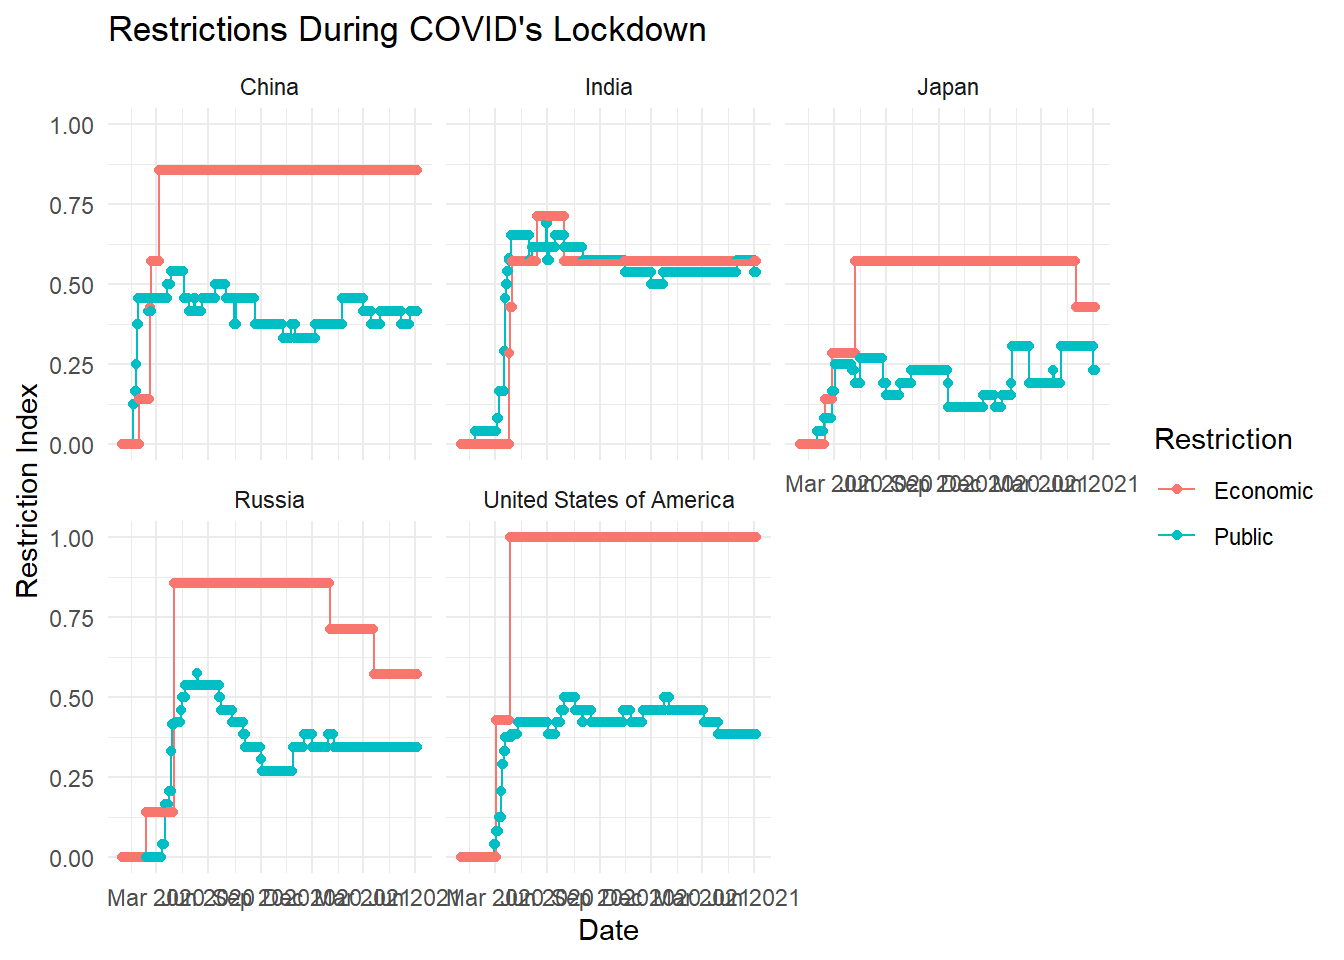

In [ ]:
df2_long <- df2 |>
  pivot_longer(cols = c(Public, Economic),
               names_to = "Restriction", values_to = "Rigidity") %>% 
  mutate(Date = as.Date(date))

#making a faceted plot
ggplot(df2_long, aes(x = Date, y = Rigidity, color = Restriction, group = interaction(Restriction, country))) +
    theme(
    axis.text.x = element_text(size = 6, angle = 60, hjust = 1),  # Remove extra comma here
    plot.margin = margin(t = 10, r = 10, b = 60, l = 10)
  ) +
  scale_x_date(date_labels = "%b %Y", 
               date_breaks = "3 months") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_line() +
  geom_point() +
  facet_wrap(~ country) +
  labs(title = "Restrictions During COVID's Lockdown", x = "Date", y = "Restriction Index") +
  theme_minimal()

Seeing if economic and public restrictions were statistically different

In [ ]:
library(car)

Loading required package: carData


Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

The following object is masked from 'package:purrr':

    some

country,n,statistic,p.value
China,521,0.7140077,0.00000000000000000000000000007276880219
India,521,0.6312080,0.00000000000000000000000000000006443471
Japan,521,0.9335874,0.00000000000001859985352188436037723651
Russia,521,0.8302978,0.00000000000000000000004190057782746653
United States of America,521,0.6186642,0.00000000000000000000000000000002486007


country,n,statistic,p.value
China,521,0.3847361,0.00000000000000000000000000000000000001491383
India,521,0.5660964,0.00000000000000000000000000000000059191545477
Japan,521,0.5591909,0.00000000000000000000000000000000037233102278
Russia,521,0.6979087,0.00000000000000000000000000001652274757775360
United States of America,521,0.4565808,0.00000000000000000000000000000000000069767096


In [ ]:
#testing for statistical significance in differences between indices for how countries handled the lockdown

kruskal.test(Public ~ country, data = df2)


    Kruskal-Wallis rank sum test

data:  Public by country
Kruskal-Wallis chi-squared = 1154.8, df = 4, p-value < 2.2e-16


    Kruskal-Wallis rank sum test

data:  Economic by country
Kruskal-Wallis chi-squared = 1189.2, df = 4, p-value < 2.2e-16

post-hoc test to see which ones are different

In [ ]:
# using Dunn's test to see which variables are different
library(dunn.test)
# Perform Dunn's Test for pairwise comparisons
dunn.test(df2$Public, g = df2$country)

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1154.8228, df = 4, p-value = 0

                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |      China      India      Japan     Russia
---------+--------------------------------------------
   India |  -13.02502
         |    0.0000*
         |
   Japan |   19.77441   32.79944
         |    0.0000*    0.0000*
         |
  Russia |   7.398060   20.42308  -12.37635
         |    0.0000*    0.0000*    0.0000*
         |
United S |  -0.342397   12.68262  -20.11681  -7.740458
         |     0.3660    0.0000*    0.0000*    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1189.222, df = 4, p-value = 0

                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |      China      India      Japan     Russia
---------+--------------------------------------------
   India |   18.28142
         |    0.0000*
         |
   Japan |   19.78936   1.507937
         |    0.0000*     0.0658
         |
  Russia |   6.583489  -11.69793  -13.20587
         |    0.0000*    0.0000*    0.0000*
         |
United S |  -8.959188  -27.24061  -28.74855  -15.54267
         |    0.0000*    0.0000*    0.0000*    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2

Results: The United States has significantly lower public restrictions than every other country except China. For further exploration, make a table of the number of days each type of lockdown took place in the US and China to compare. You would likely have to pivot df2. The difference in economic restriction indices was the same in each country.

2.1 look in colnames for energy consumption by sector or any indication. describe what energy metrics are present.

Proportion of CO2 emitted by top 5 countries in 2022

In [ ]:
#for all greenhouse gases
total_emissions <- data %>% 
  select(total_ghg, year, country, iso_code) %>%
  filter(!is.na(iso_code)) %>% 
  group_by(country, na.rm = TRUE) %>% 
  filter(year == 2022) %>% 
  ungroup()

#in the five most polluting countries
totem1 <- total_emissions %>% 
  filter(country %in% c("United States", "China", "India", "Japan", "Russia")) %>% 
  summarize(sum(total_ghg))

#in the rest of the world
totem2 <- total_emissions %>% 
  filter(!country %in% c("United States", "China", "India", "Japan", "Russia")) %>% 
  summarize(sum(total_ghg, na.rm = TRUE))

27168.36 / (27168.36 + 26138.06)

[1] 0.5096639

In [ ]:
#for co2_excluding_luc_per_capita
percap_emissions <- data %>% 
  select(ghg_excluding_lucf_per_capita, year, country, iso_code) %>%
  filter(!is.na(iso_code)) %>% 
  group_by(country, na.rm = TRUE) %>% 
  filter(year == 2022) %>% 
  ungroup()

#in the five most polluting countries
totemcap1 <- percap_emissions %>% 
  filter(country %in% c("United States", "China", "India", "Japan", "Russia")) %>% 
  summarize(mean(ghg_excluding_lucf_per_capita))

#in the rest of the world
totemcap2 <- percap_emissions %>% 
  filter(!country %in% c("United States", "China", "India", "Japan", "Russia")) %>% 
  summarize(mean(ghg_excluding_lucf_per_capita, na.rm = TRUE))

Results The top five biggest co2 emitted of the world emitted a total of 27168.36 million metric tons of greenhouse gases in 2022. That year, the other 213 countries emitted metric tons of greenhouse gasses, meaning 50.97 percent of greenhouse gas emissions come from the top 5 most polluting countries. The mean emissions per capita in the top 5 biggest greenhouse gas emitters was 10.45 CO2 equivalents versus a mean of only 5.59 CO2 equivalents for the rest of the countries.

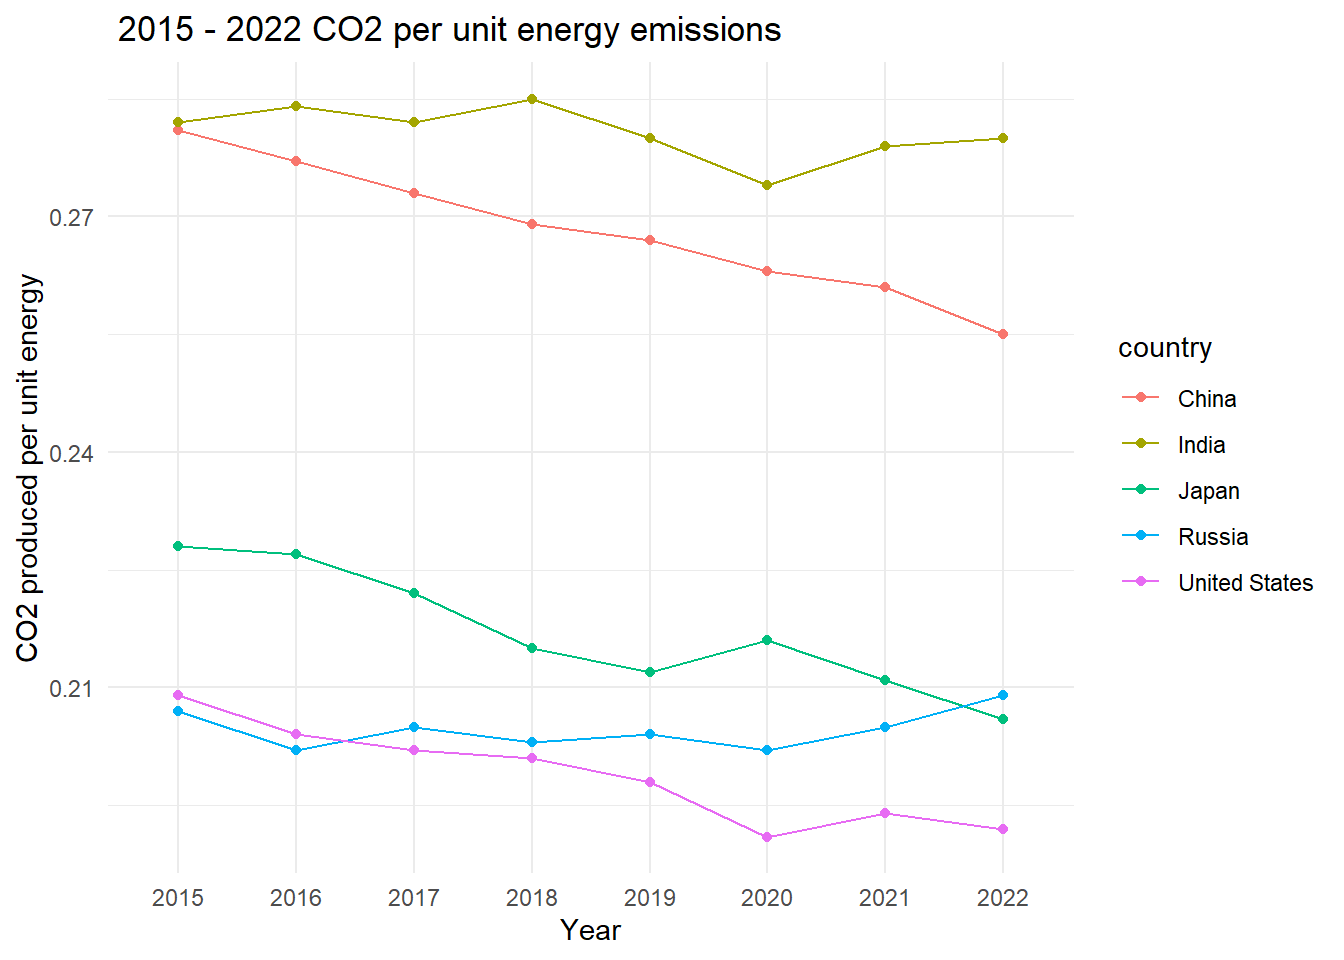

In [ ]:
#co2_per_unit_energy
 
df3 <- data_filtered %>% 
  group_by(country) %>% 
  filter(country %in% c("China", "India", "Russia", "United States", "Japan")) %>%
  select(country, year, co2_per_unit_energy,
         ghg_excluding_lucf_per_capita) %>% 
  mutate(percap = ghg_excluding_lucf_per_capita, energy = co2_per_unit_energy)


ggplot(df3, aes(x = factor(year), y = co2_per_unit_energy, color = country, group = country)) +
  geom_line() +
  geom_point() +
  labs(
    title = " 2015 - 2022 CO2 per unit energy emissions",,
    x = "Year", y = "CO2 produced per unit energy"
  ) +
  theme_minimal()

1.  make ANOVA for energy consumption for the top 5 highest ghg emitting countries and top 5 highest energy consumers to see if there’s a significant difference in averages over time

In [ ]:
#shapiro test for Public restrictions
normspub2 <- df3 |> 
  nest(data = -country) |>
  mutate(
    Shapiro = map(data, ~ shapiro.test(na.omit(.x$energy))),  # Remove NAs before applying shapiro.test
    n = map_dbl(data, nrow),
    glance_shapiro = map(Shapiro, broom::glance)
  ) |>
  unnest(glance_shapiro)

flextable::flextable(dplyr::select(normspub2, country, n, statistic, p.value)) |>
  flextable::set_caption("Shapiro-Wilk normality test for energy consumption in each country")

country,n,statistic,p.value
China,8,0.9880975,0.9915808
India,8,0.9287910,0.5051372
Japan,8,0.9407402,0.6183777
Russia,8,0.9249849,0.4716001
United States,8,0.9545535,0.7569171


ANOVA for co2 emissions per unit energy

`bins`.

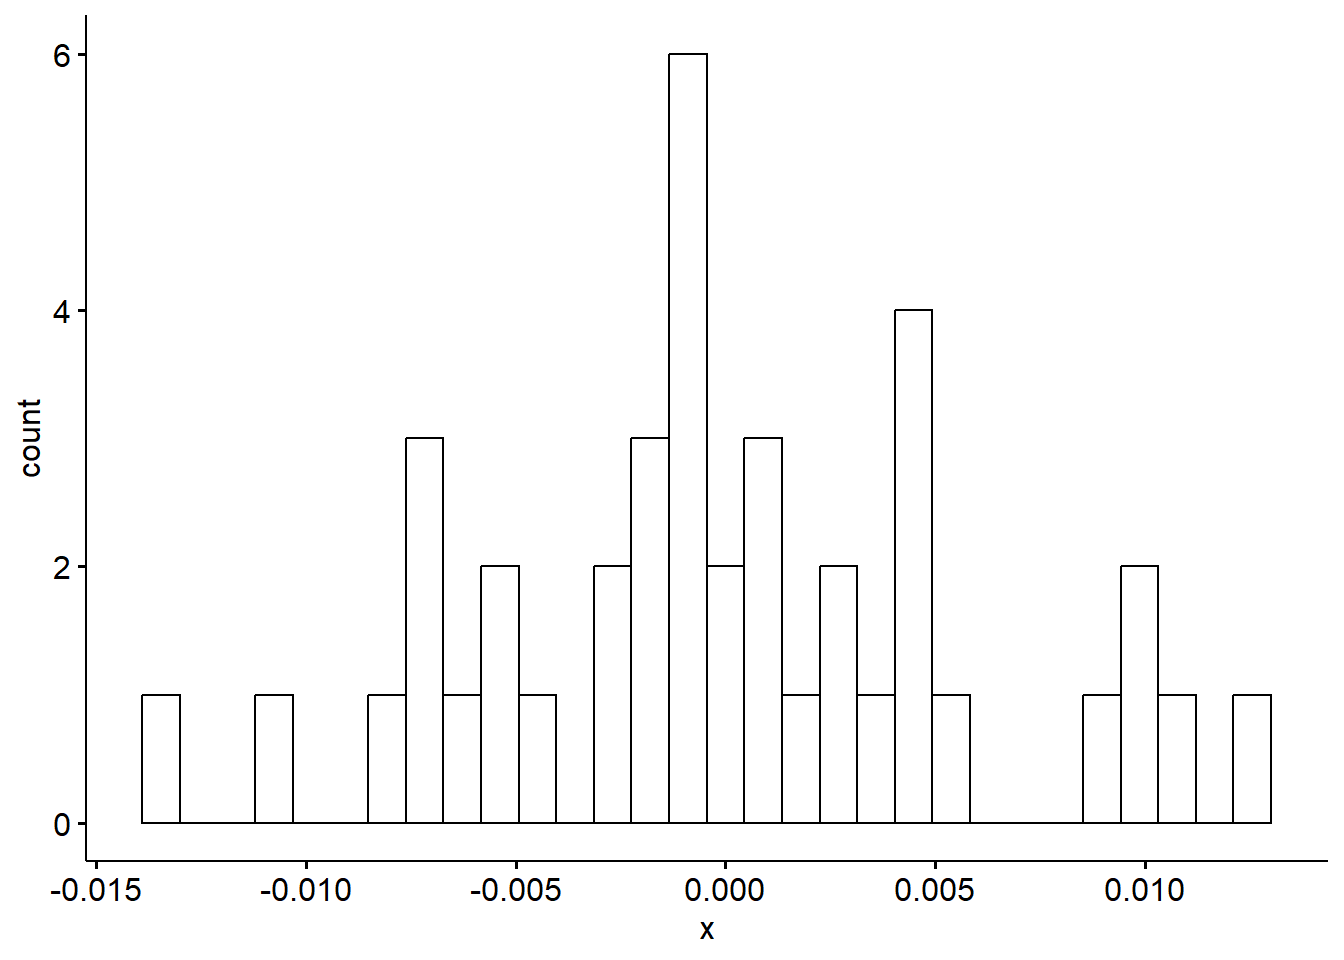


    Shapiro-Wilk normality test

data:  res_aov$residuals
W = 0.98372, p-value = 0.8234

In [ ]:
library(ggpubr)

res_aov <- aov(formula = co2_per_unit_energy ~ country, data = df3)

#making sure residuals have a normal distribution
gghistogram(res_aov$residuals)

`bins`.

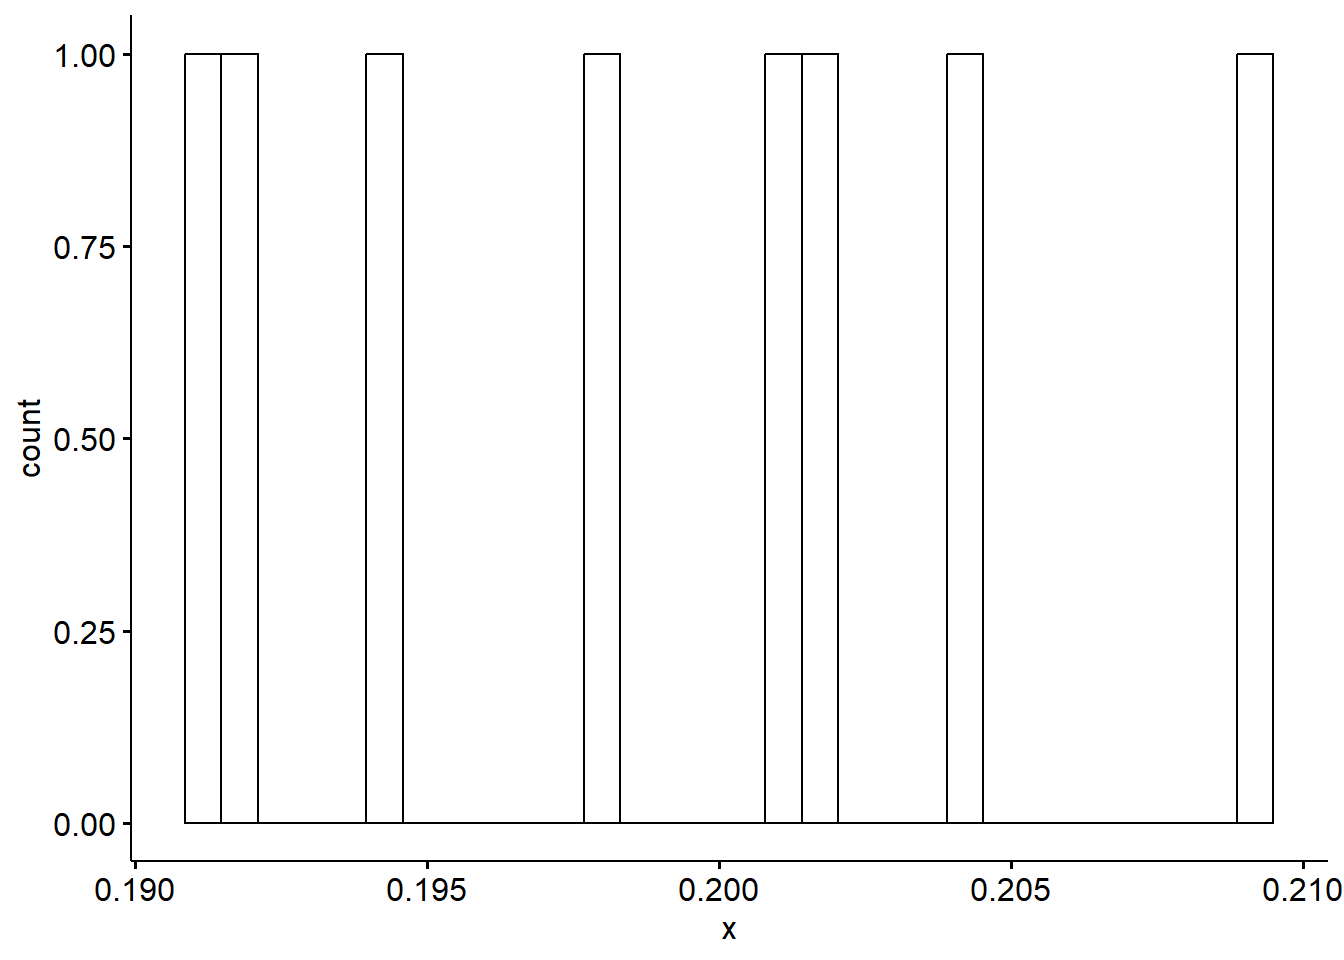


    Shapiro-Wilk normality test

data:  df3$energy
W = 0.8199, p-value = 1.81e-05

In [ ]:
library(ggpubr)
norm_usa <- df3 %>% group_by(country) %>% 
filter(country == "United States")

gghistogram(norm_usa$energy)

p-values from ANOVA

In [ ]:
summary(aov(formula = co2_per_unit_energy ~ country, data = df3))

            Df  Sum Sq  Mean Sq F value Pr(>F)    
country      4 0.04592 0.011480   297.1 <2e-16 ***
Residuals   35 0.00135 0.000039                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Results:

There is a statistically significant difference (p \< 0.000) in CO2 per kilowatt-hour for the top 5 biggest cumulative CO2 emitters.

Look at lab 4 for ANOVA, edit code to reflect dataset

1.  primary goal: make a ML model for energy consumption based on lab 6 government responses to COVID as a variable in ML model

## Predicting CO2 Emissions per unit Energy

In [ ]:
#set a seed
set.seed(341)

#doing a correlation test for variables

ghg_per_eny <- data_filtered %>% 
  mutate(period = case_when(
    year <= 2019 ~ "pre_covid",
    year == 2020 ~ "during_covid",
    year >= 2021 ~ "post_covid"
  )) %>% 
  group_by(country) %>% 
  mutate(gdp_percap = gdp/population) %>% 
  ungroup() %>% 
select(co2_per_unit_energy, share_global_luc_co2,
gas_co2_per_capita, oil_co2_per_capita, gdp_percap, coal_co2_per_capita, share_global_coal_co2, cumulative_luc_co2, share_global_luc_co2) %>%
  drop_na

cor(ghg_per_eny)

                      co2_per_unit_energy share_global_luc_co2
co2_per_unit_energy            1.00000000          -0.06205943
share_global_luc_co2          -0.06205943           1.00000000
gas_co2_per_capita            -0.06469071          -0.04494566
oil_co2_per_capita            -0.16581272          -0.08168927
gdp_percap                    -0.34221426          -0.10968576
coal_co2_per_capita            0.32347237          -0.09014084
share_global_coal_co2          0.17452910          -0.12193451
cumulative_luc_co2             0.07446080           0.62811757
                      gas_co2_per_capita oil_co2_per_capita  gdp_percap
co2_per_unit_energy         -0.064690709        -0.16581272 -0.34221426
share_global_luc_co2        -0.044945659        -0.08168927 -0.10968576
gas_co2_per_capita           1.000000000         0.39609288  0.70568157
oil_co2_per_capita           0.396092880         1.00000000  0.63852320
gdp_percap                   0.705681571         0.63852320  1.00000000
c

## making testing and training data for energy consumption

In [ ]:
#find recipe format from lab 6 / model daily assignments
library(rsample)

set.seed(325)

ghg_per_eny_split <- initial_split(ghg_per_eny, prop = .8)
ghg_per_eny_train <- training(ghg_per_eny_split)
ghg_per_eny_test  <- testing(ghg_per_eny_split)


ghg_per_eny_cv <- vfold_cv(ghg_per_eny, v = 10)

In [ ]:
#attempted recipe format
library(recipes)


Attaching package: 'recipes'

The following object is masked from 'package:stringr':

    fixed

The following object is masked from 'package:stats':

    step

In [ ]:
#making the models
library(parsnip)

boost <- boost_tree() %>%
  # define the engine
  set_engine("xgboost") %>%
  # define the mode
  set_mode("regression")

nnet <- bag_mlp() %>%
  # define the engine
  set_engine("nnet") %>%
  # define the mode
  set_mode("regression")

dtree <- decision_tree() %>%
  # define the engine
  set_engine("rpart") %>%
  # define the mode
  set_mode("regression")

rf <- rand_forest(
  mtry = 5,
  trees = 1000,
  min_n = 5
) %>%
  set_engine("ranger", importance = "impurity") %>%  # <-- ADD THIS
  set_mode("regression")  

Plotting the best predictive models of emissions per unit energy

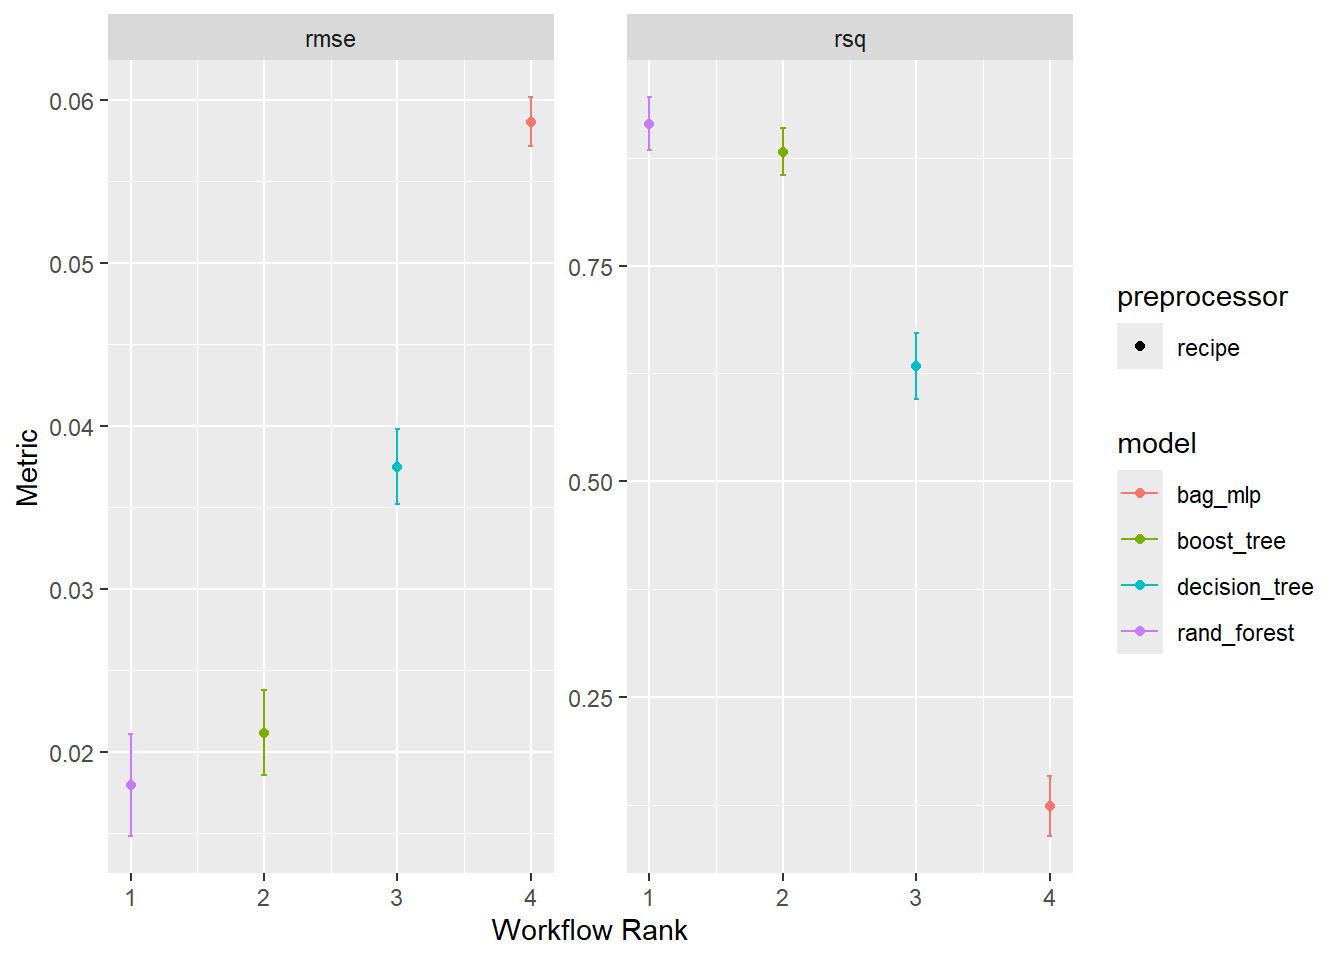

In [ ]:
library(workflowsets)
library(baguette)

wf <-  workflow_set(list(rec_energy), 
                  list(boost,
                       nnet,
                       dtree,
                       rf)) %>%
  workflow_map('fit_resamples', resamples = ghg_per_eny_cv) 

autoplot(wf)

Results:

The graph shows that random forest is the best model for predicting carbon emissions per unit energy.

In [ ]:
rank_results(wf, rank_metric = "rsq", select_best = TRUE)

# A tibble: 8 × 9
  wflow_id         .config .metric   mean std_err     n preprocessor model  rank
  <chr>            <chr>   <chr>    <dbl>   <dbl> <int> <chr>        <chr> <int>
1 recipe_rand_for… Prepro… rmse    0.0179 1.90e-3    10 recipe       rand…     1
2 recipe_rand_for… Prepro… rsq     0.915  1.84e-2    10 recipe       rand…     1
3 recipe_boost_tr… Prepro… rmse    0.0212 1.58e-3    10 recipe       boos…     2
4 recipe_boost_tr… Prepro… rsq     0.882  1.67e-2    10 recipe       boos…     2
5 recipe_decision… Prepro… rmse    0.0375 1.40e-3    10 recipe       deci…     3
6 recipe_decision… Prepro… rsq     0.634  2.31e-2    10 recipe       deci…     3
7 recipe_bag_mlp   Prepro… rmse    0.0586 9.09e-4    10 recipe       bag_…     4
8 recipe_bag_mlp   Prepro… rsq     0.123  2.13e-2    10 recipe       bag_…     4

The random forest does best in this situation to model ghg emissions per unit energy

In [ ]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom     1.0.7     ✔ tune      1.3.0
✔ dials     1.4.0     ✔ workflows 1.2.0
✔ infer     1.0.7     ✔ yardstick 1.3.2
✔ modeldata 1.4.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ dials::prune()    masks rpart::prune()
✖ car::recode()     masks dplyr::recode()
✖ xgboost::slice()  masks dplyr::slice()
✖ car::some()       masks purrr::some()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()

[1] 158   9

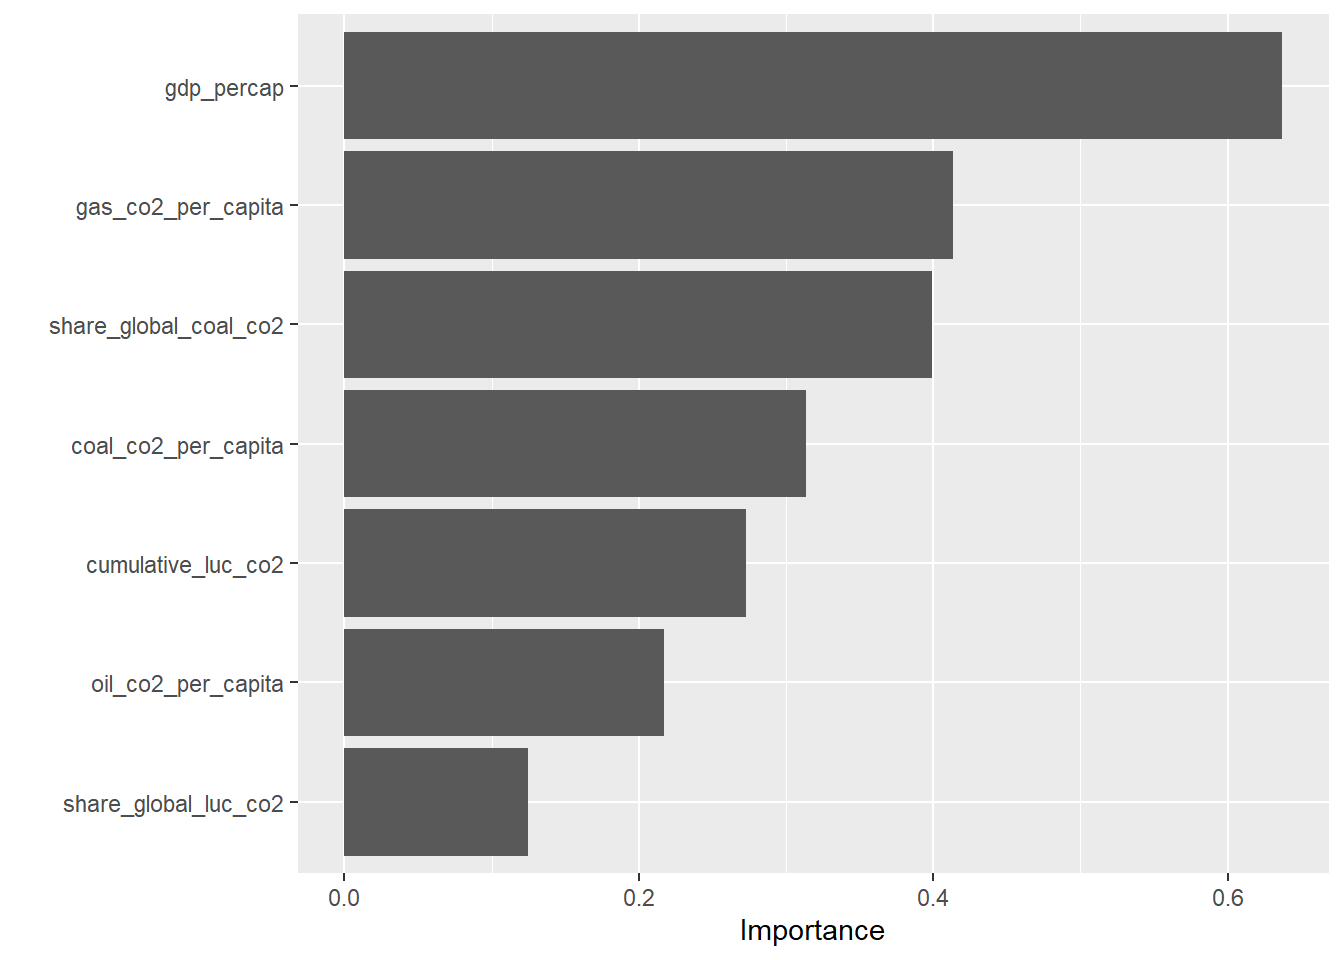

In [ ]:
#finding the most statistically significant predictors
rf_model <- extract_fit_engine(rf_wf)
vip::vip(rf_model)

Results: The most important variable for predicting CO2 emissions per unit of energy consumption during the the 2015 to 2022 period in the five countries examined was GDP per capita followed by CO2 emitted from gas per capita.

Forster, P. M., Forster, H. I., Evans, M. J., Gidden, M. J., Jones, C. D., Keller, C. A., Lamboll, R. D., Le Quéré, C., Rogelj, J., Rosen, D., et al. (2020). Current and future global climate impacts resulting from COVID-19. *Nature Climate Change*, *10*(10), 913–919.

Friedlingstein, P., Jones, M. W., O’Sullivan, M., Andrew, R. M., Hauck, J., Peters, G. P., Peters, W., Pongratz, J., Sitch, S., Le Quéré, C., et al. (2019). Global carbon budget 2019. *Earth System Science Data*, *11*(4), 1783–1838.

Samborska, V. (2025). Scaling up: How increasing inputs has made artificial intelligence more capable. *Our World in Data*.